In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os

In [4]:
os.getenv('MLFLOW_TRACKING_URI')

In [5]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)
ratings.head(10)

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [6]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [5]:
u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [6]:
# Ver parte de los diccionarios
print(dict(list(user2Idx.items())[0:10]))
print(dict(list(movie2Idx.items())[0:10]))

{196: 1, 186: 2, 22: 3, 244: 4, 166: 5, 298: 6, 115: 7, 253: 8, 305: 9, 6: 10}
{242: 1, 302: 2, 377: 3, 51: 4, 346: 5, 474: 6, 265: 7, 465: 8, 451: 9, 86: 10}


In [7]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,3,881250949
1,2,2,3,891717742
2,3,3,1,878887116
3,4,4,2,880606923
4,5,5,1,886397596


In [9]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)


In [10]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [11]:
ratings_train.head()

,userId,movieId,rating,timestamp
20000,392,13,2,877399864
20001,457,882,4,886365297
20002,111,61,4,875306477
20003,176,1315,2,874951695
20004,122,658,4,877879172


In [12]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [13]:
# Por el embedding que arranca en 1
ratings_train['userId'].max(), ratings_train['movieId'].max()

(943, 1682)

In [14]:
from keras.layers import Embedding, Input, Flatten, Dot
from keras.regularizers import l2
from keras import Model, Sequential
from keras.constraints import non_neg

2024-07-04 18:17:00.612861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
# Parámetros

n_latent_factors = 20
learning_rate = 0.001
epochs = 20

In [89]:
movie_input = Input(shape=[1], name='Item')
# movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_embedding = Embedding(
    n_movies + 1, n_latent_factors, 
    mask_zero=True,
    # embeddings_regularizer=l2(0.001),
    name='Movie-Embedding'
)(
    movie_input
)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(
    n_users + 1, n_latent_factors, mask_zero=True, name='User-Embedding')(user_input))
#user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
#                                                  n_latent_factors,name='User-Embedding', embeddings_constraint=non_neg())(user_input))

In [90]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 20)                33660     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 20)                18880     ['User[0][0]']          

In [91]:
from keras.optimizers import Adam, SGD

In [92]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [93]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [94]:
model.compile(Adam(learning_rate=learning_rate), 'mean_squared_error', metrics=[root_mean_squared_error])

In [95]:
len(ratings_train)

80000

In [96]:
[ratings_train.userId, ratings_train.movieId]

[20000    392
 20001    457
 20002    111
 20003    176
 20004    122
         ... 
 99995    876
 99996    709
 99997     38
 99998     59
 99999    305
 Name: userId, Length: 80000, dtype: int64,
 20000      13
 20001     882
 20002      61
 20003    1315
 20004     658
          ... 
 99995     174
 99996     248
 99997    1005
 99998     444
 99999     507
 Name: movieId, Length: 80000, dtype: int64]

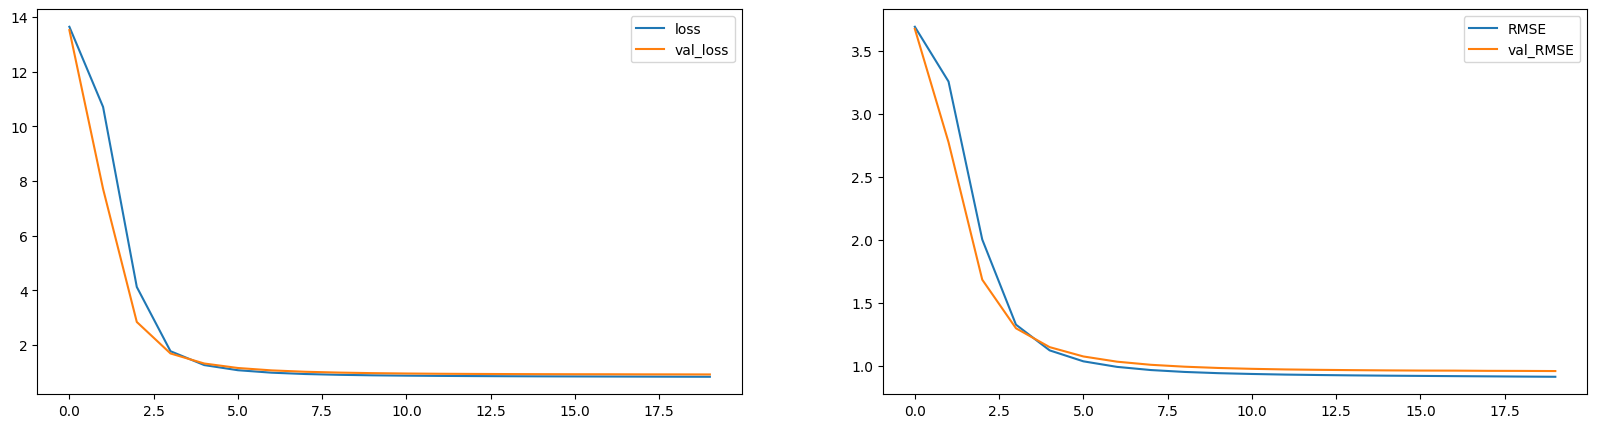

200/200 [==============================] - 1s 3ms/step - loss: 0.8368 - root_mean_squared_error: 0.9140 - val_loss: 0.9223 - val_root_mean_squared_error: 0.9595


In [97]:
history = model.fit(
    [ratings_train.userId, ratings_train.movieId], 
    ratings_train.rating, 
    batch_size=400,
    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
    epochs=epochs, 
    callbacks = [plot_losses],
    verbose=1)

In [98]:
model.metrics_names

['loss', 'root_mean_squared_error']

In [99]:
loss_val, rmse_val = model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)
loss_val, rmse_val

625/625 [==============================] - 1s 1ms/step - loss: 0.9223 - root_mean_squared_error: 0.9516


(0.9223496317863464, 0.9515638947486877)

In [100]:
loss_train, rmse_train = model.evaluate([ratings_train.userId, ratings_train.movieId], ratings_train.rating)
loss_train, rmse_train

2500/2500 [==============================] - 3s 1ms/step - loss: 0.8184 - root_mean_squared_error: 0.8965


(0.8184419870376587, 0.8964872360229492)

In [101]:
import mlflow
mlflow.set_experiment('sistemas-de-recomendación')

<Experiment: artifact_location='file:///Users/julian/Documents/repos/sistemas-de-recomendacion/mlruns/229720450832614780', creation_time=1720128221349, experiment_id='229720450832614780', last_update_time=1720128221349, lifecycle_stage='active', name='sistemas-de-recomendación', tags={}>

In [102]:
mlflow.log_params({
    'n_latent_factors': n_latent_factors,
    'learning_rate': learning_rate,
    'epochs': epochs
})

In [103]:
mlflow.log_metrics({
    'loss_val': loss_val, 'rmse_val':rmse_val,
    'loss_train': loss_train, 'rmse_train':rmse_train,
})

In [104]:
mlflow.end_run()

# Embeddings

In [106]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 20)                33660     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 20)                18880     ['User[0][0]']          

In [108]:
model.layers

In [109]:
movie_embeddings_layer = model.layers[2]
user_embeddings_layer = model.layers[3]

In [111]:
movie_embeddings_layer.name, user_embeddings_layer.name

('Movie-Embedding', 'User-Embedding')

In [115]:
movie_embeddings_layer.get_weights()[0].shape

(1683, 20)

In [118]:
user_embeddings_layer.get_weights()[0][54]

array([-0.49272838, -0.3763813 , -0.54989237, -0.44893268,  0.44349885,
       -0.43127617,  0.39833125, -0.47118184,  0.4676542 , -0.3838577 ,
        0.46160153,  0.43226236,  0.49496487, -0.48549038, -0.42564574,
       -0.54094315,  0.42494848, -0.38577464,  0.38136035,  0.393747  ],
      dtype=float32)

In [57]:
movie_embeddings_matrix = movie_embeddings_layer.get_weights()[0]
user_embeddings_matrix = user_embeddings_layer.get_weights()[0]
movie_embeddings_matrix.shape, user_embeddings_matrix.shape, n_movies, n_users

((1683, 5), (944, 5), 1682, 943)

In [60]:
import numpy as np

np.save('vectors/movie_embeddings_matrix.npy', movie_embeddings_matrix)
np.save('vectors/user_embeddings_matrix.npy', user_embeddings_matrix)
np.save('vectors/user2Idx.npy', user2Idx)
np.save('vectors/movie2Idx.npy', movie2Idx)

In [77]:
from sklearn.metrics.pairwise import pairwise_distances


In [45]:
movie_embeddings_matrix[18], movie_embeddings_matrix[17]

(array([ 0.8542718 , -0.6730329 , -0.94418526,  0.3480935 ,  1.204144  ],
       dtype=float32),
 array([ 1.086546  , -0.5747258 , -0.68991774,  0.9306461 ,  0.44092357],
       dtype=float32))

In [69]:
model_test_emb = Model(inputs=[user_input, movie_input], outputs=[movie_embedding, prod])

In [94]:
import numpy as np
movie_vects, prod = model_test_emb.predict([np.array([15, 19, 19]), np.array([19, 19, 17])])

1/1 [==============================] - 0s 72ms/step


In [95]:
movie_vects

array([[[ 0.53025186, -0.6212062 , -0.9628908 ,  0.39879707,
          1.0183728 ]],

       [[ 0.53025186, -0.6212062 , -0.9628908 ,  0.39879707,
          1.0183728 ]],

       [[ 1.086546  , -0.5747258 , -0.68991774,  0.9306461 ,
          0.44092357]]], dtype=float32)

In [97]:
pairwise_distances(movie_vects[0], movie_vects[2], metric='cosine')

array([[0.17091465]], dtype=float32)

In [102]:
from sklearn.neighbors import NearestNeighbors

In [104]:
movie_embeddings_matrix.shape

(1683, 5)

In [111]:
nn = NearestNeighbors(n_neighbors=5, metric='cosine').fit(movie_embeddings_matrix)

In [112]:
movie_vects, _ = model_test_emb.predict([np.array([15]), np.array([19])])

1/1 [==============================] - 0s 66ms/step


In [113]:
movie_vects.shape

(1, 1, 5)

In [114]:
nn.kneighbors(movie_vects[0])

(array([[1.1920929e-07, 1.6558170e-03, 2.5915504e-03, 2.6733875e-03,
         3.4774542e-03]], dtype=float32),
 array([[ 19, 634, 477, 144, 472]]))